# Generative Adversarial Network (GAN)

GAN has two components, a generator and a discriminator. The generator generates e.g. images, from random noise, and the discriminator descerns whether an image given to it (either by the generator (fake) or image file (true)) it real or fake. These two components are trained one after the other, in series, rather than in parallel.

## Generator

The generator synthesises fake images. 

In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
num_train, height, width = X_train.shape
depth = 1

### Noise

Generate noise (sometimes called latent samples) for the generator input. It is best to use random smmles from a Gaussian input, rather than Uniform. 

### Preprocessing

Flattern images and scale images to -1 and 1 for comparison with the tanh activation function of the generator.

In [4]:
def preprocess(x):    
    x = x.reshape(-1, 784) # 784=28*28
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [5]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

### Deprocessing

Must reverse preporcessing after image has been generated for visual comparison.

In [6]:
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

### Labels

We need to label the images 1, for real, and 0, for fake.

### Training

In [7]:
class GAN:
    def __init__ (self, g_hiddensize, d_hiddensize, leaky_alpha, g_learningrate, d_learningrate, sample_size):
        """Input functions of:
            g_hiddensize - the size of the hidden layer in the inital generator dense layer,
            d_hiddensize - the size of the hidden layer in the inital discriminator dense layer,
            leaky_alpha - the gradient of the straight line for x < 0 for the LeakyReLU activation function,
            g_learningrate - learning rate for the generator,
            d_learningrate - learning rate for the discriminator,
            sample_size - the size of the noise dataset.
            """
        self.g_hiddensize = g_hiddensize
        self.d_hiddensize = d_hiddensize
        self.leaky_alpha = leaky_alpha
        self.g_learningrate = g_learningrate
        self.d_learningrate = d_learningrate
        self.sample_size = sample_size
    
    def generator(self):
        inpt = Input(shape=(self.sample_size,))
        
        dense_1 = Dense(self.g_hiddensize)(inpt)
        LR = LeakyReLU(alpha=self.leaky_alpha)(dense_1)
        out = Dense(784, activation = 'tanh')(LR)
        
        generator = Model(inpt,out)
        return generator
    
    def discriminator(self,xdata):
        num_examples, shape = xdata.shape
        inpt = Input(shape=(shape,)) ### make this an input or detect the size
        
        dense_1 = Dense(self.d_hiddensize)(inpt)
        LR = LeakyReLU(alpha=self.leaky_alpha)(dense_1)
        out = Dense(1, activation = 'sigmoid')(LR)
        
        discriminator = Model(inpt,out)
        return discriminator
    
    def fit(self,xtrain_real,xtest_real,batch_size,smooth,eval_size,epochs):
        
        discriminator = self.discriminator(xtrain_real)
        generator = self.generator()
        
        gan = Sequential([
            generator,
            discriminator
        ])
        
        discriminator.compile(optimizer=Adam(lr=self.d_learningrate), loss='binary_crossentropy')
        gan.compile(optimizer=Adam(lr=self.g_learningrate), loss='binary_crossentropy')
        
        # labels for the batch size and the test size
        y_train_real, y_train_fake = self.make_labels(batch_size)
        y_eval_real,  y_eval_fake  = self.make_labels(eval_size)
        
        losses = []
        for i in range(epochs):
            for j in range(len(xtrain_real)//batch_size):
                #real images
                xbatch_real = xtrain_real[j*batch_size:(j+1)*batch_size]
                
                #noise
                noise = self.noise(batch_size,self.sample_size)
                xbatch_fake = generator.predict_on_batch(noise)
                
                #train discriminator
                self.make_trainable(discriminator,True)
                discriminator.train_on_batch(xbatch_real,y_train_real*(1-smooth))
                discriminator.train_on_batch(xbatch_fake,y_train_fake)
                
                #train generator
                self.make_trainable(discriminator,False)
                gan.train_on_batch(noise,y_train_real)
                
            # evaluate
            xeval_real = xtest_real[np.random.choice(len(xtest_real), eval_size, replace=False)]
    
            noise = self.noise(eval_size, self.sample_size)
            xeval_fake = generator.predict_on_batch(noise)

            d_loss  = discriminator.test_on_batch(xeval_real, y_eval_real)
            d_loss += discriminator.test_on_batch(xeval_fake, y_eval_fake)
            g_loss  = gan.test_on_batch(noise, y_eval_real) # we want the fake to be realistic!
    
            losses.append((d_loss, g_loss))
    
            print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(i+1, epochs, d_loss, g_loss))     
    
    def make_trainable(self,model, trainable):
        for layer in model.layers:
            layer.trainable = trainable
            
    def make_labels(self,size):
        return np.ones([size, 1]), np.zeros([size, 1])
    
    def noise(self,num_samples, sample_size):
        return np.random.normal(loc=0, scale=1, size=(num_samples, sample_size))

In [8]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hiddensize   = 128
d_hiddensize   = 128
leaky_alpha     = 0.01
g_learningrate = 0.0001  # learning rate for the generator
d_learningrate = 0.001   # learning rate for the discriminator
epochs          = 300
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1

SGAN = GAN(g_hiddensize, d_hiddensize, leaky_alpha, g_learningrate, d_learningrate, sample_size)

In [9]:
SGAN.fit(X_train_real,X_test_real,batch_size,smooth,eval_size,epochs)

/usr/lib64/python3.6/site-packages/keras/engine/training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/300 Discriminator Loss: 0.1498 Generator Loss: 2.2400
Epoch:   2/300 Discriminator Loss: 0.8699 Generator Loss: 5.7502
Epoch:   3/300 Discriminator Loss: 0.1565 Generator Loss: 2.6784
Epoch:   4/300 Discriminator Loss: 1.4616 Generator Loss: 7.0966
Epoch:   5/300 Discriminator Loss: 0.3789 Generator Loss: 1.7190
Epoch:   6/300 Discriminator Loss: 0.3946 Generator Loss: 2.7452
Epoch:   7/300 Discriminator Loss: 0.2367 Generator Loss: 2.4354
Epoch:   8/300 Discriminator Loss: 0.9011 Generator Loss: 1.1111
Epoch:   9/300 Discriminator Loss: 0.2757 Generator Loss: 2.2782
Epoch:  10/300 Discriminator Loss: 0.0795 Generator Loss: 4.0881
Epoch:  11/300 Discriminator Loss: 0.2867 Generator Loss: 2.1844
Epoch:  12/300 Discriminator Loss: 0.2918 Generator Loss: 2.3652
Epoch:  13/300 Discriminator Loss: 0.4291 Generator Loss: 3.0116
Epoch:  14/300 Discriminator Loss: 0.6654 Generator Loss: 4.2400
Epoch:  15/300 Discriminator Loss: 0.5038 Generator Loss: 3.1735
Epoch:  16/300 Discrimina

Epoch: 128/300 Discriminator Loss: 1.0886 Generator Loss: 3.1106
Epoch: 129/300 Discriminator Loss: 1.0006 Generator Loss: 2.8308
Epoch: 130/300 Discriminator Loss: 0.8845 Generator Loss: 3.2031
Epoch: 131/300 Discriminator Loss: 0.6517 Generator Loss: 2.8206
Epoch: 132/300 Discriminator Loss: 0.6253 Generator Loss: 3.2675
Epoch: 133/300 Discriminator Loss: 0.9813 Generator Loss: 3.4354
Epoch: 134/300 Discriminator Loss: 1.5151 Generator Loss: 3.3972
Epoch: 135/300 Discriminator Loss: 1.0907 Generator Loss: 3.3566
Epoch: 136/300 Discriminator Loss: 0.6916 Generator Loss: 3.3890
Epoch: 137/300 Discriminator Loss: 0.7863 Generator Loss: 3.5283
Epoch: 138/300 Discriminator Loss: 0.7470 Generator Loss: 2.5019
Epoch: 139/300 Discriminator Loss: 1.0654 Generator Loss: 3.1807
Epoch: 140/300 Discriminator Loss: 0.6044 Generator Loss: 3.0065
Epoch: 141/300 Discriminator Loss: 0.6083 Generator Loss: 2.4837
Epoch: 142/300 Discriminator Loss: 1.0535 Generator Loss: 2.5758
Epoch: 143/300 Discrimina

Epoch: 255/300 Discriminator Loss: 0.7963 Generator Loss: 1.9623
Epoch: 256/300 Discriminator Loss: 0.7608 Generator Loss: 1.7842
Epoch: 257/300 Discriminator Loss: 1.0761 Generator Loss: 1.5330
Epoch: 258/300 Discriminator Loss: 0.8938 Generator Loss: 1.3636
Epoch: 259/300 Discriminator Loss: 0.8837 Generator Loss: 2.2536
Epoch: 260/300 Discriminator Loss: 0.7855 Generator Loss: 1.7674
Epoch: 261/300 Discriminator Loss: 0.8007 Generator Loss: 2.5598
Epoch: 262/300 Discriminator Loss: 0.8352 Generator Loss: 1.9178
Epoch: 263/300 Discriminator Loss: 0.8091 Generator Loss: 1.6916
Epoch: 264/300 Discriminator Loss: 0.8094 Generator Loss: 1.9785
Epoch: 265/300 Discriminator Loss: 0.8764 Generator Loss: 1.7653
Epoch: 266/300 Discriminator Loss: 0.9848 Generator Loss: 1.7073
Epoch: 267/300 Discriminator Loss: 1.5129 Generator Loss: 1.9624
Epoch: 268/300 Discriminator Loss: 0.5339 Generator Loss: 2.2932
Epoch: 269/300 Discriminator Loss: 0.6044 Generator Loss: 2.1340
Epoch: 270/300 Discrimina

Some things to note:

1. The learning rate for the generator is lower than that of the discriminator as we want the latter to be trained first. This is reduce the likelihood of instances such as the generator learning how to trick the discriminator into accepting bad answers.

2. If the generator loss continues to go down, the generator is fooling the discriminator.

In [10]:
generator = SGAN.generator()

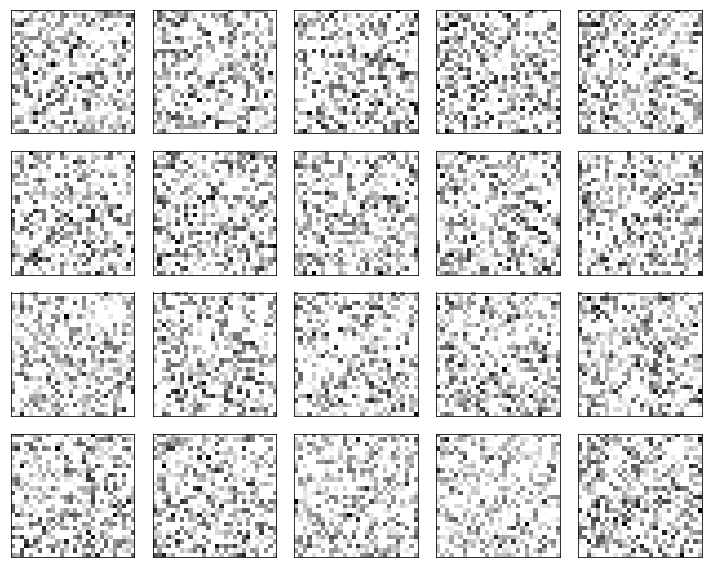

In [11]:
noise = SGAN.noise (20, sample_size)

generated_digits = generator.predict(noise)



plt.figure(figsize=(10, 8))
for i in range(20):
    img = deprocess(generated_digits[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


For a simle GAN introduction: https://github.com/naokishibuya/deep-learning/blob/master/python/gan_mnist.ipynb

For a mathematical overview: https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html

For tricks in building and speeding up GAN training: https://github.com/soumith/ganhacks